In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../..')
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.input_prep.encode import MultiEncoder, OneHotEncoderSeq, RadianEncoder 
from hamp_pred.src.input_prep.encode import RadiousPhobosEncoder
from hamp_pred.src.predictor_config import PredictionConfig 
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper 
from hamp_pred.src.predictor import Predictor

2023-10-18 16:49:29.162436: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare data

In [2]:
DATA_DIR = '../../data/input'

# data set contains train and validation sets
# the val set is used for eraly stopping 
data = f'{DATA_DIR}/af2_clean_model_1.p'
data = pd.read_pickle(data)
data['n_seq'] = data['n_seq'].apply(lambda x: x[1:-1])
data['c_seq'] = data['c_seq'].apply(lambda x: x[1:-1])
data['train_seq'] = data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
assert all(data['train_seq'].str.len() == 22)

# separate test set used to pick the best model
#data_test = f'{DATA_DIR}/af_clean_model_test.p'
#data_test = pd.read_pickle(data_test)


In [3]:
data['class'].value_counts()

train    3978
val       994
Name: class, dtype: int64

In [6]:
def get_mod(conf=None, version=None):
    operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                          parallel=True)
    conf = PredictionConfig(BaseConvolutionalWrapper, operator, conf)
    mod = Predictor('hamp_rot', config=conf, version=version)
    return mod

## Train and validate

In [4]:
def get_rmse(val, mod):
    seqs = list(val.train_seq)
    tr=[]
    for n,r in val.iterrows():
        tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
    res = mod.predict(seqs)
    pr = []
    for n,r in res.iterrows():
        pr.append(np.mean(r['N_pred'])/2)
        
    return np.mean((np.array(tr)-np.array(pr)) **2 ) ** 0.5

In [5]:
def train(data, conf, version):
    operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                          parallel=True)
    conf = PredictionConfig(BaseConvolutionalWrapper, operator, conf)
    mod = Predictor('hamp_rot', config=conf, version=version)
    trained = mod.train(data)
    return mod, trained


In [6]:
def opt_conf(data, tune=False):
    
    # data: train and val (val for the eraly stopping)
    
    data_val = data[data['class'] == 'val']
    
    results = {}

    # parameters grid
    kernels = [(3, 4, 7)]
    layers = [3]
    lstm = [1, 2]
    dense = [1, 3]
    
    for kern in kernels:
        for l in layers:
            for ls in lstm:
                for d in dense:
                    model_config = {
                        'activation': 'tanh',
                        'norm': True,
                        'n_layers': l,
                        'kernel_sizes': kern,
                        'lstm': ls,
                        'dense': d,
                        'reshape_out': False,
                        'epochs': 100
                    }
                    version = '_'.join([str(x) for x in ["_".join([str(i) for i in kern]), l, ls, d]])
                    if tune:
                        mod, trained = train(data, model_config, version)
                    else:
                        mod = get_mod(model_config, version)
                        
                    results[version] = (get_rmse(data_val, mod), model_config)
    return results
        

## Tune hiperparameters

In [7]:
#uncomment me 
#opt_res = opt_conf(data, tune=True)  

In [8]:
# kern, layers, lstm, dense
for pos, (k, (v, model_config)) in enumerate(sorted(opt_res.items(), key=lambda item: item[1])):
    if pos==0:
        best_model_config = model_config
        best_file = k
        
    print(pos+1, k, round(v, 2))

1 3_4_7_3_2_1 4.32
2 3_4_7_3_2_3 4.4
3 3_4_7_3_1_3 4.4
4 3_4_7_3_1_1 4.42


In [9]:
best_model_config

{'activation': 'tanh',
 'norm': True,
 'n_layers': 3,
 'kernel_sizes': (3, 4, 7),
 'lstm': 2,
 'dense': 1,
 'reshape_out': False,
 'epochs': 100,
 'task': 'hamp_rot',
 'version': '3_4_7_3_2_1',
 'data_dir': '/home/users/sdunin/calc/HAMPpred/data/output/weights/hamp_rot/3_4_7_3_2_1'}

## Best Config

In [4]:
best_model_config = {'activation': 'tanh',
 'norm': True,
 'n_layers': 3,
 'kernel_sizes': (3, 4, 7),
 'lstm': 2,
 'dense': 1,
 'reshape_out': False,
 'epochs': 100,
 'task': 'hamp_rot',
 'version': '3_4_7_3_2_1',
 'data_dir': '/home/users/sdunin/calc/HAMPpred/data/output/weights/hamp_rot/3_4_7_3_2_1'}

best_file = '3_4_7_3_2_1'

In [7]:
mod = get_mod(conf=best_model_config, version=best_file)

# PDB set performance

In [8]:
test_data = pd.read_pickle(f'{DATA_DIR}/pdb_measure.p')

In [9]:
test_data = pd.read_pickle(os.path.join(DATA_DIR, 'pdb_measure.p'))
test_data = test_data[~test_data.mutant]
test_data.rename(columns={'seq1':'n_seq', 'seq2':'c_seq', 'n_list':'n_crick_mut', 'c_list':'c_crick_mut'}, inplace=True)
test_data['n_seq'] = test_data['n_seq'].apply(lambda x: x[1:-1])
test_data['c_seq'] = test_data['c_seq'].apply(lambda x: x[1:-1])
test_data['train_seq'] = test_data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
len(test_data)

31

In [10]:
seq = []
tr = []
for n,r in test_data.iterrows():
    seq.append(r['n_seq'] + r['c_seq'])
    tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
res = mod.predict(seq)
pr = []
for n,r in res.iterrows():
    pr.append(np.mean(r['predicted_rotation'])/2)

2023-10-18 16:50:19.424090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 16:50:19.425915: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


1/1 [==============================] - 2s 2s/step


In [14]:
# define colors
c=[]

for pdbid, pdbrow in test_data.iterrows():
    
    # af1503
    if pdbid in [
        '0_2l7h.pdb', '1_2l7i.pdb', '2_2y0q.pdb', '3_2y20.pdb', '4_2y21.pdb',
        '5_4gn0.pdb', '6_4cq4.pdb', '12_3zrx.pdb', '13_3zrv.pdb',
        '14_3zrw.pdb', '15_3zcc.pdb', '16_2lfr.pdb', '17_2lfs.pdb',
        '18_4cti.pdb', '20_3zx6.pdb'
    ]:
        c.append('#ff0000')
    
    # narq
    elif pdbid in ['7_5iji.pdb', '8_5jeq.pdb', '9_5jef.pdb', '10_5jgp.pdb', '11_6yue.pdb']:
        c.append('#ffd700')
    
    elif pdbid in ['22_4i3m.pdb', '25_3lnr.pdb', '28_4i44.pdb']:
        c.append('#c71585')        
   
    elif pdbid in ['23_4i3m.pdb', '26_3lnr.pdb', '29_4i44.pdb']:
        c.append('#00fa9a')   
        
    elif pdbid in ['24_4i3m.pdb', '27_3lnr.pdb', '30_4i44.pdb']:
        c.append('#0000ff')  
        
    elif pdbid in ['19_4biv.pdb', '31_4biu.pdb']:
        c.append('#1e90ff') 
        
    elif pdbid in ['21_4i5s.pdb']:
        c.append('#ffdab9') 

    else:
        raise ValueError

Text(0.5, 1.0, 'HAMPpred predictions')

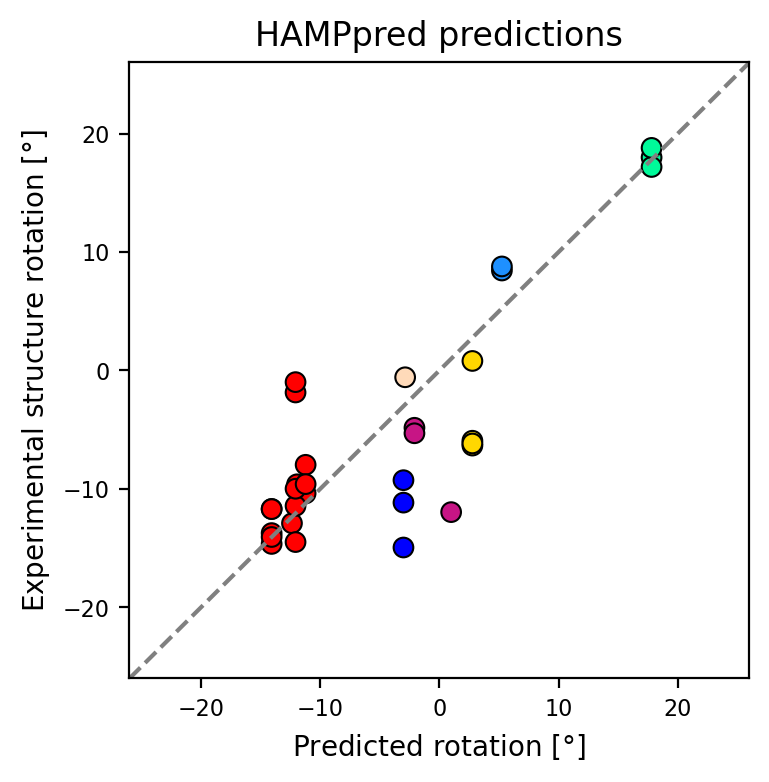

In [15]:
title_font_size = 12
label_font_size = 10
tick_font_size = 8

fig, ax = plt.subplots(1,1, figsize=(4, 4), dpi=200)

#colors = ['white' if i=='1_2l7i.pdb' else 'grey' for i in test_data.index]

ax.scatter(pr, tr, color=c, lw=0.75, edgecolors='k', s=50)

ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)
ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')

ax.set_xlabel(r'Predicted rotation [$\degree$]', size=label_font_size)
ax.set_ylabel(r'Experimental structure rotation [$\degree$]', size=label_font_size)

ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)
ax.set_title("HAMPpred predictions", size=title_font_size)

In [12]:
np.mean((np.asarray(tr)-np.asarray(pr)) **2 ) ** 0.5

5.604181337613865

In [ ]:
# Done!

In [33]:
res.iloc[0].N_pred.shape

(11, 1)